# Setup

This project requires Python 3.7 or above, TensorFlow version 2.8 or higher. The animations provided by Mathplot and the Gymnasium.

In [4]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.animation
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
# Code to make sure the GPU available will work for simulations
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


In [6]:
#  Extra libraries of gymnasium needed for classic control environments
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

# Introduction to Gymnasium

In [7]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
envs = gym.envs.registry

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The objective of the agent must move the cart left or right to keep the pole upright. The registry values are environment specifications:

In [8]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [9]:
obs, info = env.reset(seed=46)
obs

array([ 0.04056043, -0.04227732, -0.02274302,  0.01218505], dtype=float32)

In [10]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity. An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [11]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

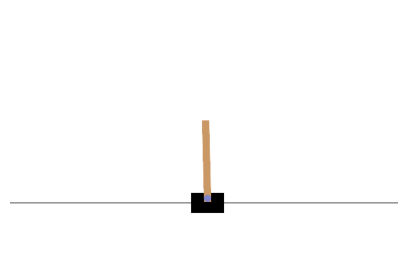

In [12]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [13]:
env.action_space

Discrete(2)

Acording to this function there are two possible actions: accelerate towards the left (0) or towards the right (1). Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [14]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.03971488,  0.15316328, -0.02249932, -0.2875859 ], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

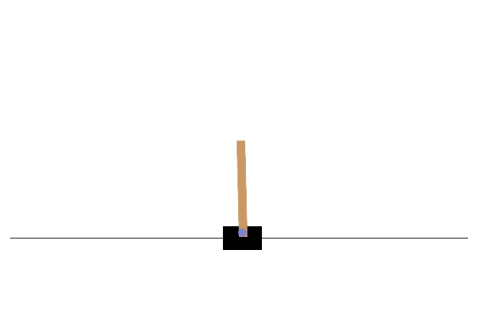

In [15]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

# **Enviroment dictionary**

The environment also tells the agent how much reward it got during the last step:

In [16]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [17]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [18]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [19]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [20]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [21]:
# condition to movev the cart
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    # reset seed per episode, ensures different initial conditions for each episode
    obs, info = env.reset(seed=episode)
    for step in range(200):
        # folowing basic policy
        action = basic_policy(obs)
        # returns the new observation, the reward, whether the episode is done or truncated 
        # (max num of steps), new info.
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [22]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the pole up for only 63 steps. This environment is considered solved when the agent keeps the pole up for 200 steps.

In [23]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)


# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [24]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

# define a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

# define policy function of the neural network
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)


In [25]:
totals = []
for episode in range(500):
    episode_rewards = 0
    # reset seed per episode, ensures different initial conditions for each episode
    obs, info = env.reset(seed=episode)
    for step in range(200):
        # folowing neural network policy
        action = pg_policy(obs)
        # returns the new observation, the reward, whether the episode is done or truncated 
        # (max num of steps), new info.
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

np.mean(totals), np.std(totals), min(totals), max(totals)

(19.526, 9.597360262072065, 8.0, 66.0)

In [26]:
# extra code to animate it
np.random.seed(42)
show_one_episode(pg_policy)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

Let's see if it can learn a better policy on its own. One that does not wobble as much.

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [27]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action)..

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [28]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [29]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [30]:
# create the neural net and reset the environment, for
# reproducibility
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [31]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [32]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 197.5

In [33]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

# Q-Learning

In [34]:
# Code obtain from https://aleksandarhaber.com/q-learning-in-python-with-tests-in-cart-pole-openai-gym-environment-reinforcement-learning-tutorial/

class Q_Learning:
    # INPUTS: 
    # env - Cart Pole environment
    # alpha - step size 
    # gamma - discount rate
    # epsilon - parameter for epsilon-greedy approach
    # numberEpisodes - total number of simulation episodes
    
    # numberOfBins - this is a 4 dimensional list that defines the number of grid points 
    # for state discretization
    # that is, this list contains number of bins for every state entry, 
    # we have 4 entries, that is,
    # discretization for cart position, cart velocity, pole angle, and pole angular velocity
    
    # lowerBounds - lower bounds (limits) for discretization, list with 4 entries:
    # lower bounds on cart position, cart velocity, pole angle, and pole angular velocity

    # upperBounds - upper bounds (limits) for discretization, list with 4 entries:
    # upper bounds on cart position, cart velocity, pole angle, and pole angular velocity
    
    def __init__(self,env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds):
        import numpy as np
        
        self.env=env
        self.alpha=alpha
        self.gamma=gamma 
        self.epsilon=epsilon 
        self.actionNumber=env.action_space.n 
        self.numberEpisodes=numberEpisodes
        self.numberOfBins=numberOfBins
        self.lowerBounds=lowerBounds
        self.upperBounds=upperBounds
        
        # this list stores sum of rewards in every learning episode
        self.sumRewardsEpisode=[]
        
        # this matrix is the action value function matrix 
        self.Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],self.actionNumber))

    
    ###########################################################################
    # for the given 4-dimensional state, and discretization grid defined by 
    # numberOfBins, lowerBounds, and upperBounds, this function will return 
    # the index tuple (4-dimensional) that is used to index entries of the 
    # of the QvalueMatrix 

    # INPUTS:
    # state - state list/array, 4 entries: 
    # cart position, cart velocity, pole angle, and pole angular velocity

    # OUTPUT: 4-dimensional tuple defining the indices of the QvalueMatrix 
    # that correspond to "state" input

    ###############################################################################
    def returnIndexState(self,state):
        position =      state[0]
        velocity =      state[1]
        angle    =      state[2]
        angularVelocity=state[3]
        
        cartPositionBin=np.linspace(self.lowerBounds[0],self.upperBounds[0],self.numberOfBins[0])
        cartVelocityBin=np.linspace(self.lowerBounds[1],self.upperBounds[1],self.numberOfBins[1])
        poleAngleBin=np.linspace(self.lowerBounds[2],self.upperBounds[2],self.numberOfBins[2])
        poleAngleVelocityBin=np.linspace(self.lowerBounds[3],self.upperBounds[3],self.numberOfBins[3])
        
        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)
        
        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])   

    # this function selects an action on the basis of the current state 
    # INPUTS: 
    # state - state for which to compute the action
    # index - index of the current episode
    def selectAction(self,state,index):
        
        # first 500 episodes we select completely random actions to have enough exploration
        if index<500:
            return np.random.choice(self.actionNumber)   
            
        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        randomNumber=np.random.random()
        
        # after 7000 episodes, we slowly start to decrease the epsilon parameter
        if index>7000:
            self.epsilon=0.999*self.epsilon
        
        # if this condition is satisfied, we are exploring, that is, we select random actions
        if randomNumber < self.epsilon:
            # returns a random action selected from: 0,1,...,actionNumber-1
            return np.random.choice(self.actionNumber)            
        
        # otherwise, we are selecting greedy actions
        else:
            # we return the index where Qmatrix[state,:] has the max value
            # that is, since the index denotes an action, we select greedy actions
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
            # here we need to return the minimum index since it can happen
            # that there are several identical maximal entries, for example 
            # import numpy as np
            # a=[0,1,1,0]
            # np.where(a==np.max(a))
            # this will return [1,2], but we only need a single index
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # note that zero has to be added here since np.where() returns a tuple
     
    def simulateEpisodes(self):
        import numpy as np
        # here we loop through the episodes
        for indexEpisode in range(self.numberEpisodes):
            
            # list that stores rewards per episode - this is necessary for keeping track of convergence 
            rewardsEpisode=[]
            
            # reset the environment at the beginning of every episode
            (stateS,_)=self.env.reset()
            stateS=list(stateS)
          
            print("Simulating episode {}".format(indexEpisode))
            
            
            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state
                
                stateSIndex=self.returnIndexState(stateS)
                
                # select an action on the basis of the current state, denoted by stateS
                actionA = self.selectAction(stateS,indexEpisode)
                
                
                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (stateSprime, reward, terminalState,_,_) = self.env.step(actionA)          
                
                rewardsEpisode.append(reward)
                
                stateSprime=list(stateSprime)
                
                stateSprimeIndex=self.returnIndexState(stateSprime)
                
                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(self.Qmatrix[stateSprimeIndex])                                               
                                             
                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0 
                    error=reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                
                # set the current state to the next state                    
                stateS=stateSprime
        
            print("Sum of rewards {}".format(np.sum(rewardsEpisode)))        
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))

    def simulateLearnedStrategy(self):
        import gym 
        import time
        env1=gym.make('CartPole-v1',render_mode='human')
        (currentState,_)=env1.reset()
        env1.render()
        timeSteps=1000
        # obtained rewards at every time step
        obtainedRewards=[]
        
        for timeIndex in range(timeSteps):
            print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated, info =env1.step(actionInStateS)
            obtainedRewards.append(reward)   
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env1

Simulating episode 0
Sum of rewards 19.0
Simulating episode 1
Sum of rewards 23.0
Simulating episode 2
Sum of rewards 31.0
Simulating episode 3
Sum of rewards 15.0
Simulating episode 4
Sum of rewards 12.0
Simulating episode 5
Sum of rewards 20.0
Simulating episode 6
Sum of rewards 14.0
Simulating episode 7
Sum of rewards 16.0
Simulating episode 8
Sum of rewards 18.0
Simulating episode 9
Sum of rewards 50.0
Simulating episode 10
Sum of rewards 16.0
Simulating episode 11
Sum of rewards 11.0
Simulating episode 12
Sum of rewards 39.0
Simulating episode 13
Sum of rewards 30.0
Simulating episode 14
Sum of rewards 21.0
Simulating episode 15
Sum of rewards 42.0
Simulating episode 16
Sum of rewards 19.0
Simulating episode 17
Sum of rewards 10.0
Simulating episode 18
Sum of rewards 14.0
Simulating episode 19
Sum of rewards 21.0
Simulating episode 20
Sum of rewards 42.0
Simulating episode 21
Sum of rewards 43.0
Simulating episode 22
Sum of rewards 21.0
Simulating episode 23
Sum of rewards 29.0
Si

c:\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

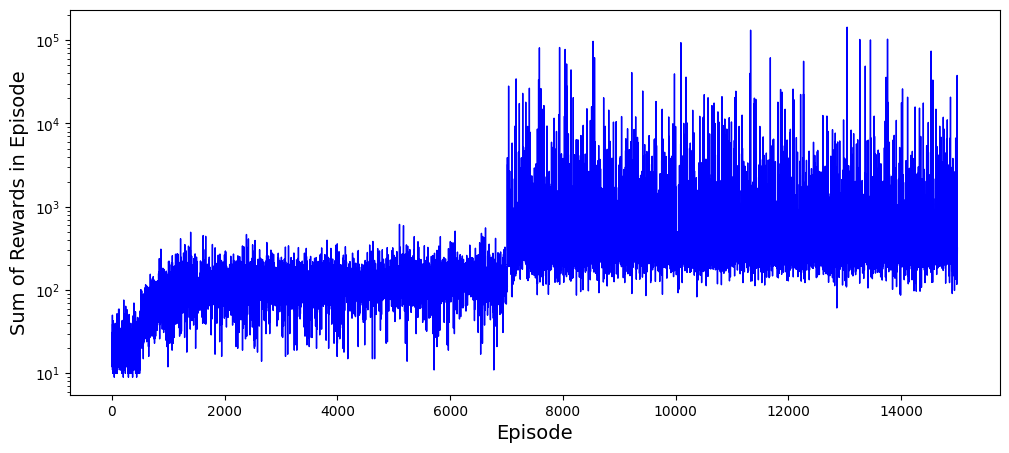

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

: 

In [35]:
#env=gym.make('CartPole-v1',render_mode='human')
env=gym.make('CartPole-v1')
(state,_)=env.reset()
#env.render()
#env.close()

# here define the parameters for state discretization
upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-3
cartVelocityMax=3
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin

numberOfBinsPosition=30
numberOfBinsVelocity=30
numberOfBinsAngle=30
numberOfBinsAngleVelocity=30
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]

# define the parameters
alpha=0.1
gamma=1
epsilon=0.2
numberEpisodes=15000

# create an object
Q1=Q_Learning(env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds)
# run the Q-Learning algorithm
Q1.simulateEpisodes()
# simulate the learned strategy
(obtainedRewardsOptimal,env1)= Q1.simulateLearnedStrategy()

plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(Q1.sumRewardsEpisode,color='blue',linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards in Episode')
plt.yscale('log')
plt.savefig('convergence.png')
plt.show()

# close the environment
env1.close()
# get the sum of rewards
np.sum(obtainedRewardsOptimal)

# run this several times and compare with a random learning strategy
(obtainedRewardsOptimal,env1)= Q1.simulateLearnedStrategy()
